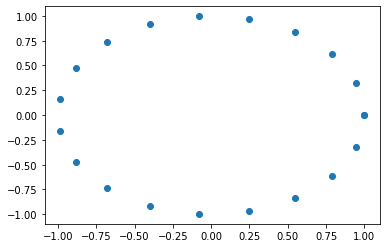

In [29]:
import numpy as np
import matplotlib.pyplot as pplot
phi_inits = np.linspace(0,2*np.pi, 20)
init_bearing_pos=[(np.cos(p_), np.sin(p_)) for p_ in phi_inits]
pplot.plot([i[0] for i in init_bearing_pos],[i[1] for i in init_bearing_pos],'o')
pplot.show()

In [30]:
np.array([[0.,0.],[0.,0.]]).shape

(2, 2)


# References:
https://www.sciencedirect.com/science/article/pii/S1007570406001523


# Maybe a bit better paper:
https://www.sciencedirect.com/science/article/pii/S1007570411000608

[Text(0.9999500004166653, 0.009999833334166664, '0'),
 Text(0.9425230106568996, 0.33414124914810184, '1'),
 Text(0.7829590279411082, 0.6220732758811577, '2'),
 Text(0.5385492856868386, 0.8425940107110873, '3'),
 Text(0.23577937187523731, 0.9718066102873135, '4'),
 Text(-0.0925408953729483, 0.9957088845056938, '5'),
 Text(-0.4108329206875351, 0.9117106510726687, '6'),
 Text(-0.6846048243160519, 0.728914421947589, '7'),
 Text(-0.8841891724915766, 0.4671290049318935, '8'),
 Text(-0.9879579042190475, 0.15472291197850244, '9'),
 Text(-0.984666067278022, -0.17444980926109901, '10'),
 Text(-0.8746703832791732, -0.48471818679957146, '11'),
 Text(-0.6698905913426674, -0.742459827620708, '12'),
 Text(-0.392517759410684, -0.9197444256679224, '13'),
 Text(-0.07260953770598559, -0.9973604438888295, '14'),
 Text(0.25516705406221696, -0.9668969823725844, '15'),
 Text(0.5552923361979911, -0.8316552298637803, '16'),
 Text(0.795243077458354, -0.6062907287387516, '17'),
 Text(0.9490168918083779, -0.31522

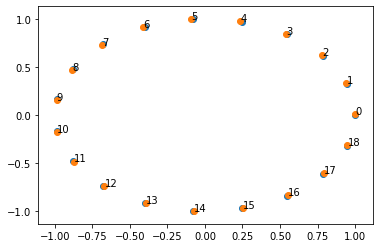

In [31]:
class Ball:
    """
    The balls of the ball bearings. 
    These should not get any loads when on the 
    side oposite to the one having the load application. 
    
    The object contains a stiffness (conditional on position) that is used in the BallBearing class
    to compute forces.
    
    """
    def __init__(self,position_phi0, stiffness, ball_init_radius, r0=0.5):
        self.position_phi0 = position_phi0
        self.position_phi = position_phi0
        self.r0 = r0
        
        self.px = np.cos(self.position_phi)
        self.py = np.sin(self.position_phi)
        
        self.ball_init_radius = ball_init_radius
        self.base_K = stiffness[0]
        self.internal_random_scale = 0.02/0.0025;
        
    def move_to_angle(self, dphi):
        self.position_phi = self.position_phi0 + dphi
        self.px = np.cos(self.position_phi)
        self.py = np.sin(self.position_phi)
    

    def get_pos(self):
        return self.px, self.py
    
    def get_K(self):
        self.K = self.base_K * (1-np.sin(self.internal_random_scale * self.position_phi*4)*0.001)
        return self.K
    
    def get_reaction_forces(self):
        pos = self.get_pos()
        c = np.cos(self.position_phi)
        s = np.sin(self.position_phi)
        x = c * self.r0
        y = s * self.r0
        YY = self.get_K() * (x * c + y * s) ** 0.666 
        if YY<0:
            return np.array([0,0])
        else:
            return np.array([YY * c, YY*s])
    
    
    def J(self):
        c = np.cos(self.position_phi)
        s = np.sin(self.position_phi)
        R = np.array([[c , -s],[s, c]])
        return R
    
    def K_glob(self):
        R = self.J()
        return R.T @ self.get_stiffness_xy() @ R
        


class BallBearing:
    def __init__(self,nbearings,  stiffnesses = None, ball_rad = None):
        self.nbearings = nbearings
        #self.r_bearing = rbearing
        
        self.pos_ball_bearings_phi = np.linspace(0,2*np.pi,nbearings)[:-1]
        
        self.stiffnesses = stiffnesses
        self.ball_rad = ball_rad
        self.balls = [Ball(p,s,r) for p,s,r in zip(self.pos_ball_bearings_phi, self.stiffnesses, self.ball_rad)]
    
    def move_to_angle(self,dphi):
        for b in self.balls:
            b.move_to_angle(dphi)
            
    def get_positions(self):
        pos = [];
        for i in self.balls:
            pos.append(i.get_pos())
            
        return np.array(pos)
    
    def get_ball_forces(self):
        all_forces = [];
        
        for b in self.balls:
            all_forces.append(b.get_reaction_forces())
            
        return np.vstack(all_forces)
    
    
    
nbearings = 19
stiffnesses = 1+np.random.randn(nbearings,1)*0.1
ball_rad = 1+np.random.randn(nbearings,1)*0.01
bb = BallBearing(20, stiffnesses = stiffnesses, ball_rad = ball_rad)
p = bb.get_positions()
pplot.scatter(p[:,0],p[:,1])

bb.move_to_angle(0.01)
p = bb.get_positions()
pplot.scatter(p[:,0],p[:,1])
[pplot.text(x,y,s) for x,y,s in zip(p[:,0],p[:,1],np.array(["%i"%i for i in range(p.shape[0])]))]

## State-space form of the equation of motion (for the whole bearing)
The force applied to the outer rail from each bearing at position $[x,y]$ reads:
\begin{align}
F^i_x = k_i [x \cos \tilde \theta_i  + y \sin \tilde \theta_i]^p_{+} \cos \tilde \theta_i \\ 
F^i_y = k_i [x \cos \tilde \theta_i  + y \sin \tilde \theta_i]^p_{+} \sin \tilde \theta_i \\ 
\end{align}
It is not clear at all from [the paper](https://www.sciencedirect.com/science/article/pii/S1007570406001523) what $p$ means, but it looks like an exponent having to do with the relative geometry of the bearings and the races. Moreover, 

\begin{equation}
F_x = \sum_{i}^{N_b} F^i_x
\end{equation}

where $N_b $  is the number of bearings. The full equations of motion for the $x$ and $y$ displacement of the outer race read (for constant angular velocity):

\begin{align}
\frac{dx}{dt} &= u_x\\
\frac{dy}{dt} &= u_y\\
\frac{d \dot u_x}{dt} &= -\frac{c}{m} u_x - \frac{F_x(x,y)}{m}\\
\frac{d \dot u_y}{dt} &= -\frac{c}{m} u_y - \frac{F_y(x,y)}{m} - W\\
\frac{dF_x}{dt} &= \frac{\partial F_x}{\partial x}u_x + \frac{\partial F_x}{\partial y}u_y \\
\frac{dF_y}{dt} &= \frac{\partial F_y}{\partial x}u_y+ \frac{\partial F_y}{\partial y}u_y  \\ 
\frac{d\theta}{dt} &= \Theta \\ 
\end{align}

where $\Theta$ is a constant angular velocity.

In [32]:
W = 2.;
theta_dot = 1.;
c = 10.;
m= 0.5;
Kx = 1000000.;
Ky = 1000000.;

Wy_reaction = -W*m;

def dF(F, t):
    # F: x,y,ux,uy
    x,y,ux,uy = F
    theta=t*500;
    bb.move_to_angle(theta);
    dx = ux
    dy = uy 
    
    v = bb.get_ball_forces()
    vc_ = v[:,1]>0
    r_fx = v[vc_,1]
    # Linear redistr. of foces:
    c_ = r_fx / np.sum(r_fx) * Wy_reaction
    v_corr = np.zeros_like(v)
    
    v_corr[vc_] = np.vstack([v[vc_,0] * c_, v[vc_,1] * c_]).T    
    
    #vtot = np.sum(v_corr,0)
    
    vtot = np.sum(v_corr,0)
    dux = -c / m * ux - vtot[0]/m - Kx * x
    duy = -c / m * uy - vtot[1]/m - W - Ky * y
    
    return dx,dy,dux,duy


from scipy.integrate import odeint

#v0 = np.array([ 0.00114048,  0.00352584, -0.33910674,  0.0940813 ])#v[-1]
v0 = [0,0,0,0];
#v0 = v[-1];
#v0 = v[-1]
t = np.linspace(0,1,1000)
v = odeint(dF, v0,t)
    

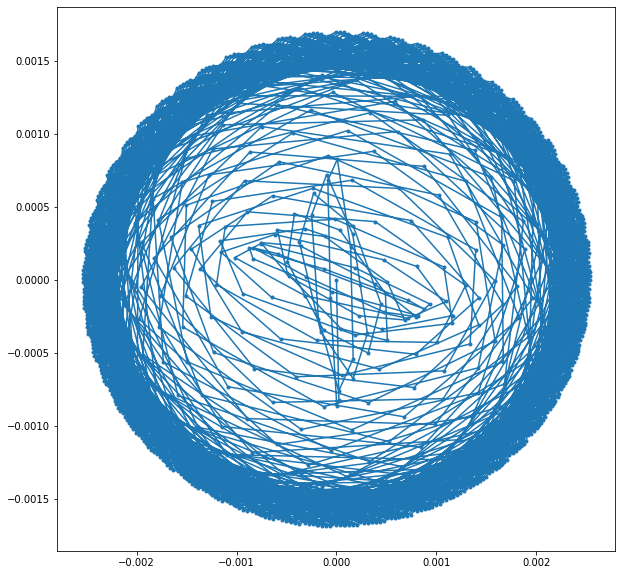

array([ 1.42329086e-06, -2.38840824e-06,  2.11363422e-03,  9.59071119e-04])

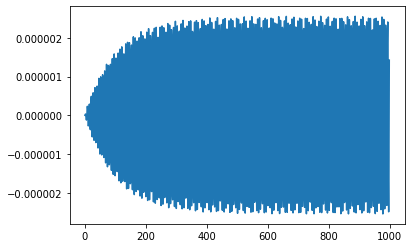

In [33]:
#pplot.figure(figsize = (50,10))

pplot.figure(figsize = (10,10))

pplot.plot(v[0:2*10*300,2],v[0:2*10*300,3],'.-')
#pplot.plot(v[250:500,2],v[250:500,3],'.-')
#pplot.plot(v[500:750,2],v[500:750,3],'.-')
pplot.show()
pplot.plot(v[:,0])
#pplot.ylim([-10,10])
v[-1]

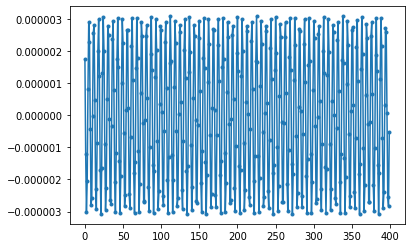

In [27]:
#pplot.plot(v[:400,1],'.-')
pplot.plot(v[-400:,0],'.-')

In [26]:
tmax = np.max(t)
t_i = np.linspace(0,tmax,tmax*8000)

#help(np.interp)

In [11]:
import IPython.display as ipd
x = np.random.randn(22000*5,)
x_ = np.interp(t_i, t[100:],np.sqrt(v[100:,3]**2 + v[100:,2]**2) )
#x = np.hstack([x_,x_,x_])
ipd.Audio(x_, rate=8000) # load a NumPy array


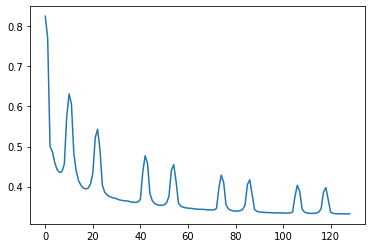

In [23]:
from scipy.signal  import  stft
pplot.plot(np.sum(np.abs(stft(x_)[2]),1)**0.1)

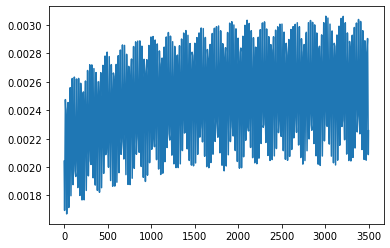

In [25]:
pplot.plot(x_[1500:5000])

Exception ignored in: <bound method Wave_write.__del__ of <wave.Wave_write object at 0x7fddba905f28>>
Traceback (most recent call last):
  File "/usr/lib/python3.6/wave.py", line 316, in __del__
    self.close()
  File "/usr/lib/python3.6/wave.py", line 434, in close
    self._ensure_header_written(0)
  File "/usr/lib/python3.6/wave.py", line 457, in _ensure_header_written
    self._write_header(datasize)
  File "/usr/lib/python3.6/wave.py", line 474, in _write_header
    self._sampwidth * 8, b'data'))
struct.error: ushort format requires 0 <= number <= (0x7fff * 2 + 1)


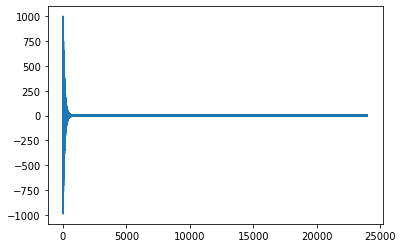

In [259]:
pplot.plot(dv)

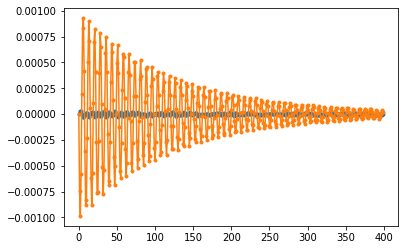

In [239]:
#pplot.plot(v[:,0], v[:,1])
#pplot.show()
#pplot.plot(v[:,2], v[:,3])
#pplot.plot(v[:400,0],'.-')
pplot.plot(v[:400,2],'.-')
pplot.plot(v[:400,3],'.-')


# Elastic loads on bearings

In [206]:

v = bb.total_force_from_ux()
#v = v
#p = bb.get_positions()

#pplot.quiver(p[:,0],p[:,1], v[:,0],v[:,1])
np.vstack(v)


[0. 0.]


array([[ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [-0.09360542, -0.97448347],
       [-0.40220149, -0.88524482],
       [-0.6759517 , -0.71526055],
       [-0.92034432, -0.48259954],
       [-0.98242524, -0.15074865],
       [-0.93332386,  0.168329  ],
       [-0.8807099 ,  0.4916274 ],
       [-0.66856424,  0.74560792],
       [-0.39988452,  0.94508245],
       [-0.06947719,  0.99684814]])

In [207]:
from ipywidgets import FloatSlider, interact, interactive

Wx = 1.
Wy = 0.
@interact(ang = FloatSlider(min = 0, max = 6.28, steps = 100))
def aa_(ang):
    
    bb.move_to_angle(ang)
    v = bb.total_force_from_ux(1.)
    v = np.vstack(bb.get_ball_forces())
    vc_ = v[:,1]>0
    r_fx = v[vc_,1]
    # Linear redistr. of foces:
    c_ = r_fx / np.sum(r_fx) * Wx
    v_corr = np.zeros_like(v)
    v_corr[vc_] = np.vstack([v[vc_,0] * c_, v[vc_,1] * c_]).T
    
    vtot = np.sum(v_corr,0)
    p = bb.get_positions()

    #pplot.quiver(p[:,0],p[:,1], v[:,0],v[:,1])
    pplot.quiver(p[:,0],p[:,1], v_corr[:,0],v_corr[:,1])
    pplot.quiver([0],[0], vtot[0],vtot[1])
    
    pplot.xlim([-2,2])
    pplot.ylim([-2,2])
    
    
    #v = bb.total_force_from_x(1.)
    #v = v.T
    #pplot.plot(v[:,1]**2 + v[:,0]**2)

interactive(children=(FloatSlider(value=0.0, description='ang', max=6.28), Output()), _dom_classes=('widget-in…

array([[-0.2826783 ,  0.15629016],
       [-0.48733769,  0.53906654],
       [-0.25016031,  0.58458408],
       [-0.07685543,  1.04156808],
       [-0.88095199,  0.15518377]])

In [135]:
help(pplot.quiver)

Help on function quiver in module matplotlib.pyplot:

quiver(*args, data=None, **kw)
    Plot a 2D field of arrows.
    
    Call signature::
    
      quiver([X, Y], U, V, [C], **kw)
    
    Where *X*, *Y* define the arrow locations, *U*, *V* define the arrow
    directions, and *C* optionally sets the color.
    
    **Arrow size**
    
    The default settings auto-scales the length of the arrows to a reasonable size.
    To change this behavior see the *scale* and *scale_units* parameters.
    
    **Arrow shape**
    
    The defaults give a slightly swept-back arrow; to make the head a
    triangle, make *headaxislength* the same as *headlength*. To make the
    arrow more pointed, reduce *headwidth* or increase *headlength* and
    *headaxislength*. To make the head smaller relative to the shaft,
    scale down all the head parameters. You will probably do best to leave
    minshaft alone.
    
    **Arrow outline**
    
    *linewidths* and *edgecolors* can be used to customi

In [101]:
p

array([[ 0.99995   ,  0.00999983],
       [ 0.94252301,  0.33414125],
       [ 0.78295903,  0.62207328],
       [ 0.53854929,  0.84259401],
       [ 0.23577937,  0.97180661],
       [-0.0925409 ,  0.99570888],
       [-0.41083292,  0.91171065],
       [-0.68460482,  0.72891442],
       [-0.88418917,  0.467129  ],
       [-0.9879579 ,  0.15472291],
       [-0.98466607, -0.17444981],
       [-0.87467038, -0.48471819],
       [-0.66989059, -0.74245983],
       [-0.39251776, -0.91974443],
       [-0.07260954, -0.99736044],
       [ 0.25516705, -0.96689698],
       [ 0.55529234, -0.83165523],
       [ 0.79524308, -0.60629073],
       [ 0.94901689, -0.31522522]])